## Set-up environment

First, we install the HuggingFace Transformers library (from source for now, as the model was recently added to the library and is under active development). This might take a few minutes.

In [1]:
!pip install -q transformers

**Optional:** Install Pillow, matplotlib and OpenCV if you are running this notebook locally.

In [2]:
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q opencv-python

## Load pre-trained model and processor

Let's first apply the image preprocessing and tokenize the text queries using `OwlViTProcessor`. The processor will resize the image(s), scale it between [0-1] range and normalize it across the channels using the mean and standard deviation specified in the original codebase.


Text queries are tokenized using a CLIP tokenizer and stacked to output tensors of shape [batch_size * num_max_text_queries, sequence_length]. If you are inputting more than one set of (image, text prompt/s), num_max_text_queries is the maximum number of text queries per image across the batch. Input samples with fewer text queries are padded.

In [3]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

## Preprocess input image and text queries

You can use one or multiple text prompts per image to search for the target object(s). Let's start with a simple example where we search for multiple objects in a single image.

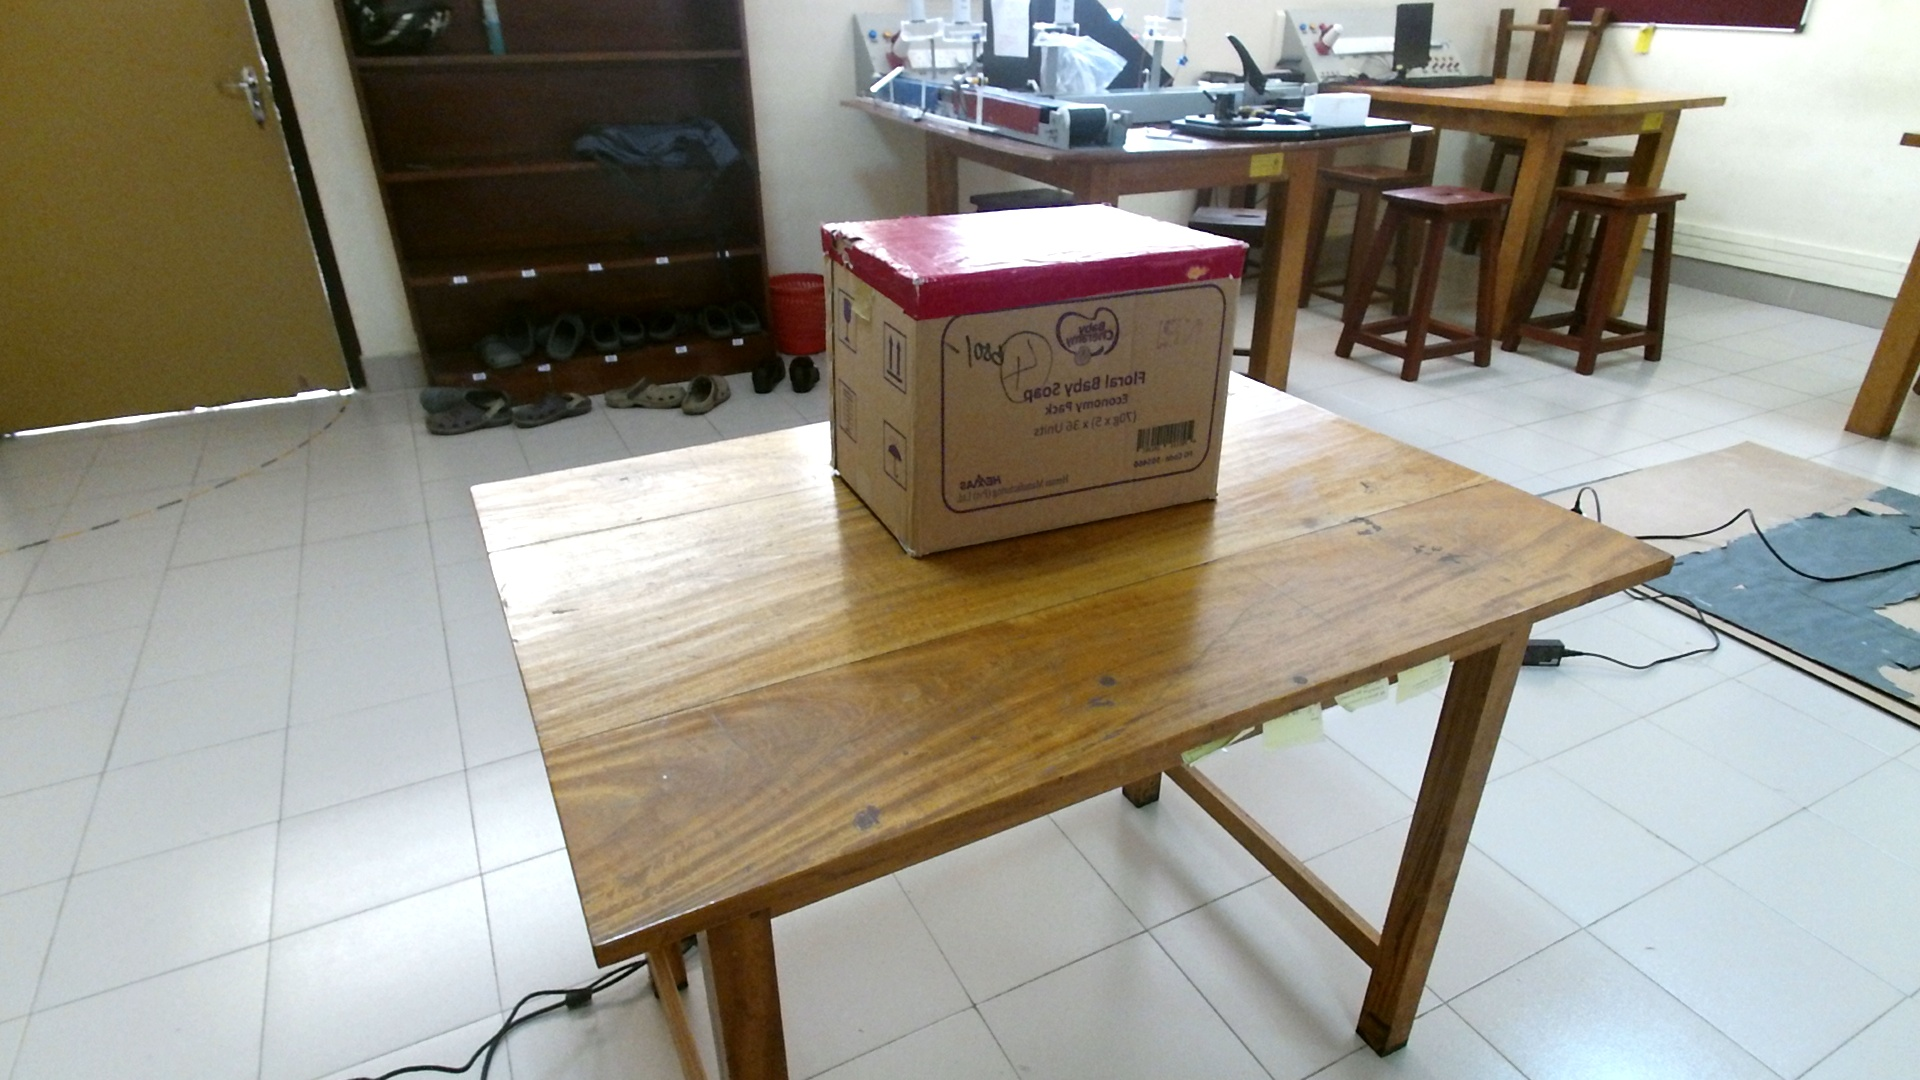

In [11]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
# image = skimage.data.astronaut()

image = Image.open("box.jpg")
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["box"]

image

In [6]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    print("gpu is available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

gpu is available


In [12]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([1, 16])
attention_mask: torch.Size([1, 16])
pixel_values: torch.Size([1, 3, 768, 768])


## Forward pass

Now we can pass the inputs to our OWL-ViT model to get object detection predictions.

`OwlViTForObjectDetection` model outputs the prediction logits, boundary boxes and class embeddings, along with the image and text embeddings outputted by the `OwlViTModel`, which is the CLIP backbone.

In [13]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 1])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 1, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([1, 16, 512])
pooler_output: shape of torch.Size([1, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


## Draw predictions on image

Let's draw the predictions / found objects on the input image. Remember the found objects correspond to the input text queries.

In [14]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

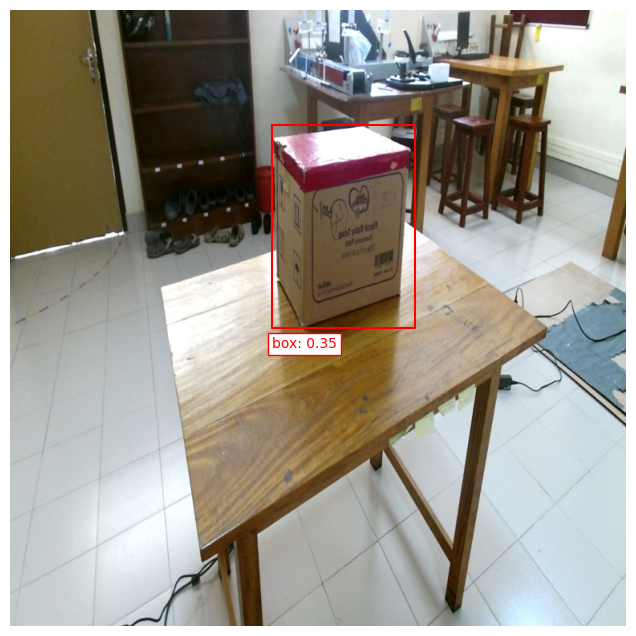

In [15]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)

In [ ]:
def convert_boxes_to_flattened_points(boxes):
  """
  Converts bounding boxes (center coordinates, width, and height) to a list of
  points representing the top-left and bottom-right corners.

  Args:
      boxes: A NumPy array of shape (num_boxes, 4) containing predicted bounding boxes
             (center_x, center_y, width, height).

  Returns:
      A list of lists of points, where each inner list represents the
      top-left and bottom-right corners of a bounding box.
  """
  flattened_boxes = []
  for box in boxes:
    # Unpack center coordinates, width, and height
    cx, cy, w, h = box

    # Calculate top-left and bottom-right coordinates
    top_left_x = cx - w / 2
    top_left_y = cy + h / 2
    bottom_right_x = cx + w / 2
    bottom_right_y = cy - h / 2

    # Create a list of points for the current bounding box
    box_points = [
        [top_left_x, top_left_y],
        [bottom_right_x, bottom_right_y]
    ]

    # Add the box points to the final list
    flattened_boxes.append(box_points)

  return flattened_boxes
convert_boxes_to_flattened_points(boxes)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [18]:
import torch
from transformers import SamModel, SamProcessor

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

model.safetensors:  78%|#######8  | 2.00G/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

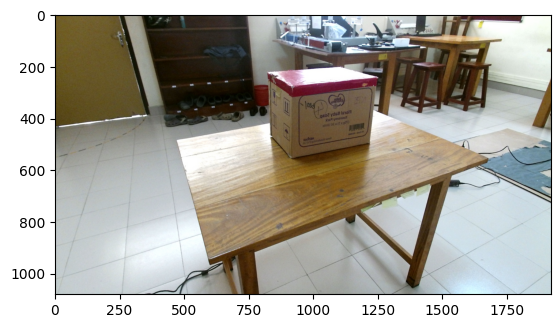

In [24]:
raw_image = Image.open("box.jpg")

plt.imshow(raw_image)

In [21]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

In [22]:
boxes

array([[0.05153886, 0.05467472, 0.1020902 , 0.10748495],
       [0.06978513, 0.08222692, 0.1129925 , 0.16400549],
       [0.49309042, 0.1801987 , 0.99518424, 0.34954965],
       ...,
       [0.88243043, 0.99981016, 0.11961681, 0.12043644],
       [0.9267046 , 0.99962234, 0.16340841, 0.26942918],
       [0.9999012 , 0.99986875, 0.23867606, 0.13631351]], dtype=float32)

IndexError: list index out of range

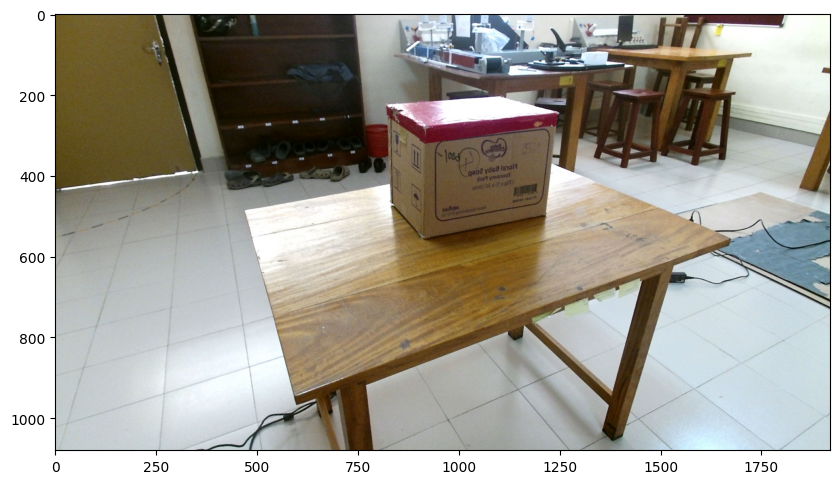

In [26]:
# input_boxes = [[[650, 900, 1000, 1250]]]
input_boxes = convert_boxes_to_flattened_points(boxes)

show_boxes_on_image(raw_image, input_boxes[0])

## Batch processing
We can also pass in multiple sets of images and text queries to search for different (or same) objects in different images. Let's download an image of a coffee mug to process alongside the astronaut image.

For batch processing, we need to input text queries as a nested list to `OwlViTProcessor` and images as lists of (PIL images or PyTorch tensors or NumPy arrays).

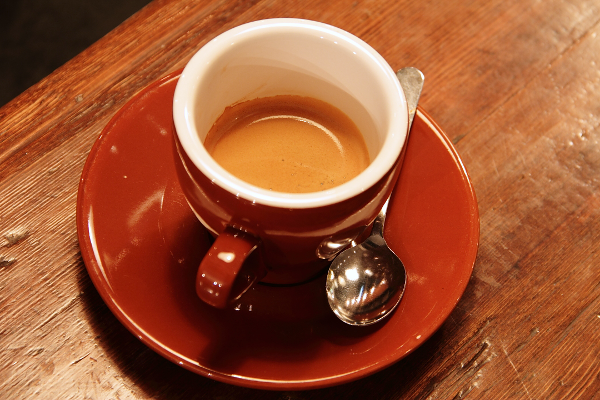

In [ ]:
# Download the coffee mug image
image = skimage.data.coffee()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image

In [ ]:
# Preprocessing
images = [skimage.data.astronaut(), skimage.data.coffee()]
images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in images]

# Nexted list of text queries to search each image for
text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate"]]

# Process image and text inputs
inputs = processor(text=text_queries, images=images, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([8, 16])
attention_mask: torch.Size([8, 16])
pixel_values: torch.Size([2, 3, 768, 768])


**Note:** Notice the size of the `input_ids `and `attention_mask` is `[batch_size * num_max_text_queries, max_length]`. Max_length is set to 16 for all OWL-ViT models.

In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([2, 576, 4])
pred_boxes: shape of torch.Size([2, 576, 4])
text_embeds: shape of torch.Size([2, 4, 512])
image_embeds: shape of torch.Size([2, 24, 24, 768])
class_embeds: shape of torch.Size([2, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([8, 16, 512])
pooler_output: shape of torch.Size([8, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([2, 577, 768])
pooler_output: shape of torch.Size([2, 768])


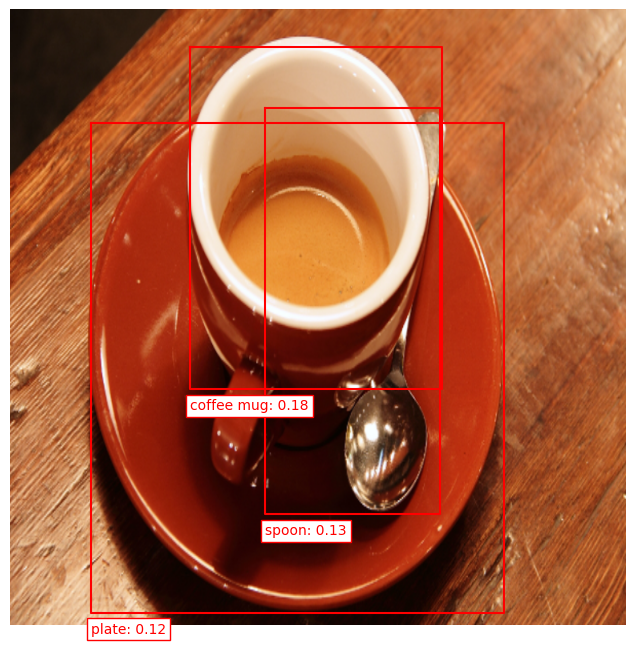

In [ ]:
# Let's plot the predictions for the second image
image_idx = 1
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

## Post-processing model predictions
Notice how we printed the output predictions on the resized input image. This is because OWL-ViT outputs normalized box coordinates in `[cx, cy, w, h]` format assuming a fixed input image size. We can use the `OwlViTProcessor`'s convenient post_process() method to convert the model outputs to a COCO API format and retrieve rescaled coordinates (with respect to the original image sizes) in `[x0, y0, x1, y1]` format.

In [ ]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([img.size[::-1] for img in images]).to(device)

# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

# Loop over predictions for each image in the batch
for i in range(len(images)):
    print(f"\nProcessing image {i}")
    text = text_queries[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    score_threshold = 0.1
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]

        if score >= score_threshold:
            print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Processing image 0
Detected human face with confidence 0.357 at location [180.23, 71.53, 271.25, 178.76]
Detected rocket with confidence 0.106 at location [358.81, 64.85, 424.18, 280.84]
Detected star-spangled banner with confidence 0.138 at location [1.43, 1.26, 105.38, 509.68]
Detected rocket with confidence 0.211 at location [350.98, -1.17, 468.6, 288.51]
Detected nasa badge with confidence 0.281 at location [129.58, 348.54, 206.46, 427.98]
Detected nasa badge with confidence 0.12 at location [277.15, 338.86, 327.42, 380.85]

Processing image 1
Detected coffee mug with confidence 0.175 at location [175.23, 24.72, 420.98, 246.83]
Detected spoon with confidence 0.132 at location [248.54, 63.72, 418.45, 327.98]
Detected plate with confidence 0.115 at location [78.9, 74.04, 481.06, 391.81]


/home/rafael/anaconda3/envs/hf/lib/python3.11/site-packages/transformers/models/owlvit/image_processing_owlvit.py:421: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


## Bonus: one-shot / image-guided object detection
Instead of performing zero-shot detection with text inputs, we can use the `OwlViTForObjectDetection.image_guided_detection()` method to query an input image with a query / example image and detect similar looking objects. To do this, we simply pass in `query_images` instead of text to the processor to get the `query_pixel_values`. Note that, unlike text input, `OwlViTProcessor` expects one query image per target image we'd like to query for similar objects. We will also see that the output and post-processing of one-shot object detection is very similar to the zero-shot / text-guided detection.

Let's try this out by querying an image with cats with another random cat image. For this part of the demo, we will perform image-guided object detection, post-process the results and display the predicted boundary boxes on the original input image using OpenCV.

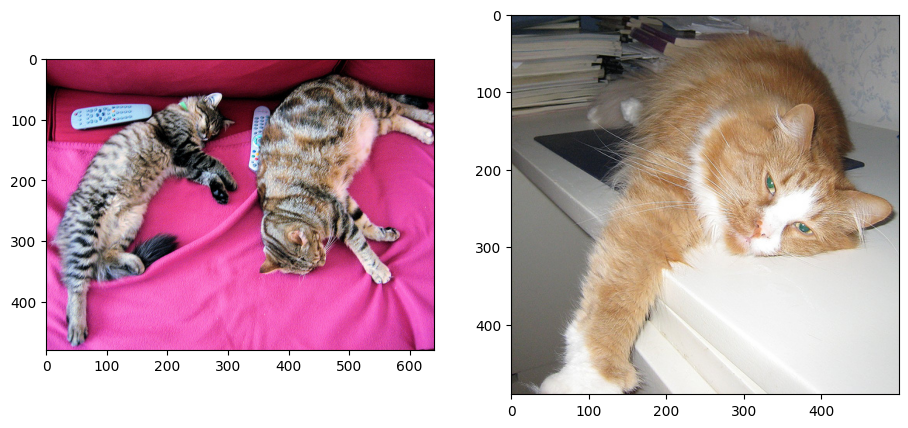

In [ ]:
import cv2
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [ ]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


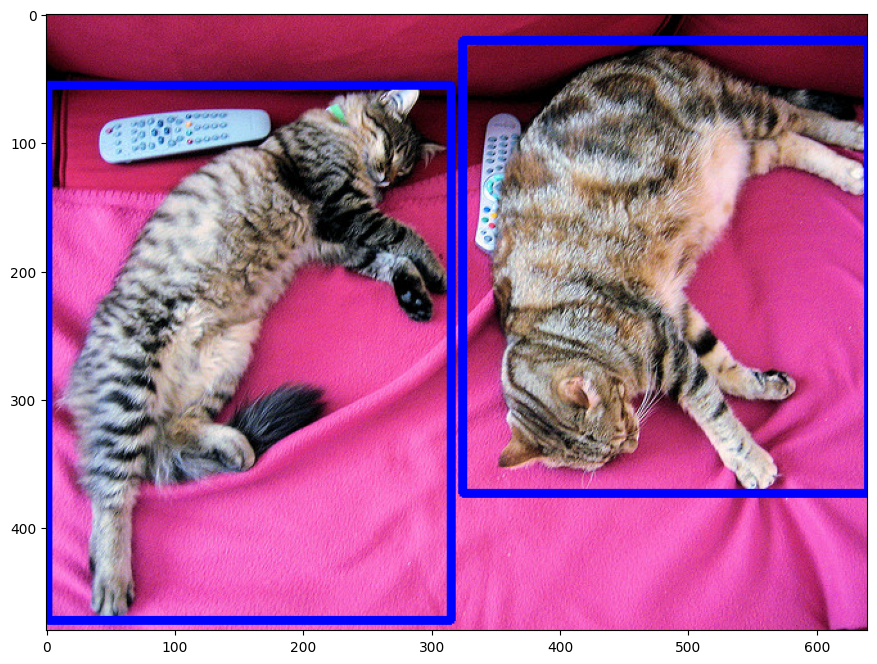

In [ ]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

plt.imshow(img[:,:,::-1])